In [25]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [26]:
pl.seed_everything(0)

Seed set to 0


0

### Gather performance and plotting

This script is to plot the prediction performance of different models in the OPS dataset (metric:L1 loss)
And will save the summary results in csv for later use if needed 

In [27]:
# load in data
dataset = 'vit_SupConLoss_epoch10_one_third_0.005'
test_set_name = '5_fold_split'

In [28]:
epochs = 100
tolerance_epochs = 20
mxAlpha = 2.0
validation_set_ratio = 0.1
validation_ood_ratio = 0.15
latdim_ctrl=50
latdim_ptb=50
geneset_num=20

prior_list = ['DepMap_GeneEffect']
model_type = 'mvae_attention_vae_14_3'
recon_loss = 'mmd'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
classifier = 'log_reg' # svm_rbf or log_reg (choose which classifier to use) 

In [29]:
if test_set_name == '5_fold_split':
    test_set_ids = ['random_fold_1', 'random_fold_2', 'random_fold_3', 'random_fold_4', 'random_fold_5']
    random_seeds = [12]

### Step 1. Read in all results in csv

In [30]:
model_path = f'/home/che/perturb-project/predict_model/result/ops/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}'

In [31]:
result_df = pd.DataFrame()
ctrl_df = pd.DataFrame()
true_df = pd.DataFrame()

for test_set_id in test_set_ids:
    # load in attention model results
    for random_seed in random_seeds:
        vae_attention_path_parent_temp = (f'{model_path}/{test_set_id}/{dataset}/recon_loss_{recon_loss}/null_label_{null_label}/epochs_100/tolerance_epochs_{tolerance_epochs}/'
                                          f'mxAlpha_{mxAlpha}/val_{validation_set_ratio}_ood_{validation_ood_ratio}/random_seed_{random_seed}')
        
        for prior in prior_list:
            pattern = f'{vae_attention_path_parent_temp}/{prior}_{model_type}_run*'
            vae_attention_path_temp = glob.glob(pattern)
            assert len(vae_attention_path_temp) == 1, f'Error: {pattern}'
            vae_attention_path_temp = vae_attention_path_temp[0]
            result_df_temp = pd.read_csv(f'{vae_attention_path_temp}/{classifier}_pred_df_denoised.csv')
            result_df_temp['prior'] = prior
            result_df_temp['random_seed'] = random_seed
            result_df_temp['model_path'] = vae_attention_path_temp
            result_df_temp['test_set_id'] = test_set_id
            result_df_temp['model'] = 'MORPH'
            result_df = pd.concat([result_df, result_df_temp])

            # load in control results
            ctrl_df_temp = pd.read_csv(f'{vae_attention_path_temp}/ctrl_pred_df.csv')
            ctrl_df_temp['random_seed'] = random_seed
            ctrl_df_temp['model_path'] = vae_attention_path_temp
            ctrl_df_temp['test_set_id'] = test_set_id
            ctrl_df_temp['model'] = 'Control distribution'
            ctrl_df = pd.concat([ctrl_df, ctrl_df_temp])

            # load in true chi2 results
            true_df_temp = pd.read_csv(f'{vae_attention_path_temp}/chi2_test_set_true_df.csv')
            true_df_temp['random_seed'] = random_seed
            true_df_temp['model_path'] = vae_attention_path_temp
            true_df_temp['test_set_id'] = test_set_id
            true_df_temp['model'] = 'True chi2'
            true_df = pd.concat([true_df, true_df_temp])

In [32]:
# load in baseline results
knn_df = pd.DataFrame()
linear_df = pd.DataFrame()
ridge_df = pd.DataFrame()

for test_set_id in test_set_ids:
    baseline_path = f'{model_path}/{test_set_id}/{dataset}/baselines/{prior_list[0]}/l1'
    knn_df_temp = pd.read_csv(f'{baseline_path}/knn_regression_pred_df.csv')
    knn_df_temp['prior'] = prior_list[0]
    knn_df_temp['random_seed'] = random_seed
    knn_df_temp['model_path'] = baseline_path
    knn_df_temp['test_set_id'] = test_set_id
    knn_df_temp['model'] = 'KNN'
    knn_df = pd.concat([knn_df, knn_df_temp])

    linear_df_temp = pd.read_csv(f'{baseline_path}/linear_regression_pred_df.csv')
    linear_df_temp['prior'] = prior_list[0]
    linear_df_temp['random_seed'] = random_seed
    linear_df_temp['model_path'] = baseline_path
    linear_df_temp['test_set_id'] = test_set_id
    linear_df_temp['model'] = 'Linear regression'
    linear_df = pd.concat([linear_df, linear_df_temp])

    ridge_df_temp = pd.read_csv(f'{baseline_path}/ridge_regression_pred_df.csv')
    ridge_df_temp['prior'] = prior_list[0]
    ridge_df_temp['random_seed'] = random_seed
    ridge_df_temp['model_path'] = baseline_path
    ridge_df_temp['test_set_id'] = test_set_id
    ridge_df_temp['model'] = 'Ridge regression'
    ridge_df = pd.concat([ridge_df, ridge_df_temp])

### Step 2. Put results together in one table and save as a csv file

In [33]:
selected_columns = ['l1_loss', 'model', 'random_seed', 'model_path', 'test_set_id']

result_df = result_df.set_index('gene')
result_df = result_df[selected_columns + ['prior', 'alpha_denoised']]

ctrl_df = ctrl_df.set_index('gene')
ctrl_df = ctrl_df[selected_columns]

knn_df = knn_df.set_index('gene')
knn_df = knn_df[selected_columns + ['prior']]
linear_df = linear_df.set_index('gene')
linear_df = linear_df[selected_columns + ['prior']]
ridge_df = ridge_df.set_index('gene')
ridge_df = ridge_df[selected_columns + ['prior']]

In [34]:
all_results = pd.concat([result_df, ctrl_df, knn_df, linear_df, ridge_df])
all_results

,l1_loss,model,random_seed,model_path,test_set_id,prior,alpha_denoised
gene,,,,,,,
ABCA4,0.044280,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_1,DepMap_GeneEffect,50.0
ABR,0.067906,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_1,DepMap_GeneEffect,50.0
ACAA2,0.049641,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_1,DepMap_GeneEffect,50.0
ACAD10,0.044720,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_1,DepMap_GeneEffect,50.0
ACLY,0.085701,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_1,DepMap_GeneEffect,50.0
...,...,...,...,...,...,...,...
ZPLD1,0.045409,Ridge regression,12,/home/che/perturb-project/predict_model/result...,random_fold_5,DepMap_GeneEffect,NaN
ZSCAN4,0.040488,Ridge regression,12,/home/che/perturb-project/predict_model/result...,random_fold_5,DepMap_GeneEffect,NaN
ZSCAN22,0.088811,Ridge regression,12,/home/che/perturb-project/predict_model/result...,random_fold_5,DepMap_GeneEffect,NaN


### Step 3. Calculate l1 loss by alpha thresholds

In [36]:
true_df = true_df.set_index('gene')

In [37]:
true_df['pval_adj'] = true_df['p-value'] * true_df.shape[0] # Bonferroni correction
true_df['rank'] = true_df['chi2'].rank(ascending=False)
true_df

,chi2,p-value,random_seed,model_path,test_set_id,model,pval_adj,rank
gene,,,,,,,,
A1BG,1.638050,0.650793,12,/home/che/perturb-project/predict_model/result...,random_fold_1,True chi2,11466.327359,14460.0
A4GALT,1.815121,0.611650,12,/home/che/perturb-project/predict_model/result...,random_fold_1,True chi2,10776.660428,14049.0
AADAC,6.470094,0.090849,12,/home/che/perturb-project/predict_model/result...,random_fold_1,True chi2,1600.675781,5442.0
AADACL2,7.226995,0.065004,12,/home/che/perturb-project/predict_model/result...,random_fold_1,True chi2,1145.306386,4661.0
AADACL4,3.009959,0.390092,12,/home/che/perturb-project/predict_model/result...,random_fold_1,True chi2,6873.035849,11289.0
...,...,...,...,...,...,...,...,...
ZPLD1,5.427732,0.143026,12,/home/che/perturb-project/predict_model/result...,random_fold_5,True chi2,2519.966875,6863.0
ZSCAN4,9.175062,0.027052,12,/home/che/perturb-project/predict_model/result...,random_fold_5,True chi2,476.623180,3111.0
ZSCAN22,9.690022,0.021393,12,/home/che/perturb-project/predict_model/result...,random_fold_5,True chi2,376.931184,2844.0


In [38]:
# get the rank when adjusted p-value is less than 0.05 and 0.01
rank_dict = {}
true_df_005 = true_df[true_df['pval_adj'] < 0.05]
rank_dict['0.05'] = true_df_005['rank'].max()

true_df_001 = true_df[true_df['pval_adj'] < 0.01]
rank_dict['0.01'] = true_df_001['rank'].max()

print(rank_dict)

{'0.05': 400.0, '0.01': 353.0}


In [39]:
merged_df = all_results.merge(true_df[['rank']], left_index=True, right_index=True)
merged_df = merged_df.sort_values('rank')
merged_df

,l1_loss,model,random_seed,model_path,test_set_id,prior,alpha_denoised,rank
gene,,,,,,,,
RAB7A,0.619499,Control distribution,12,/home/che/perturb-project/predict_model/result...,random_fold_3,NaN,NaN,1.0
RAB7A,0.280782,Linear regression,12,/home/che/perturb-project/predict_model/result...,random_fold_3,DepMap_GeneEffect,NaN,1.0
RAB7A,0.281661,Ridge regression,12,/home/che/perturb-project/predict_model/result...,random_fold_3,DepMap_GeneEffect,NaN,1.0
RAB7A,0.191849,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_3,DepMap_GeneEffect,50.0,1.0
RAB7A,0.511816,KNN,12,/home/che/perturb-project/predict_model/result...,random_fold_3,DepMap_GeneEffect,NaN,1.0
...,...,...,...,...,...,...,...,...
RDH11,0.010625,Ridge regression,12,/home/che/perturb-project/predict_model/result...,random_fold_2,DepMap_GeneEffect,NaN,17619.0
RDH11,0.010524,Linear regression,12,/home/che/perturb-project/predict_model/result...,random_fold_2,DepMap_GeneEffect,NaN,17619.0
RDH11,0.001696,MORPH,12,/home/che/perturb-project/predict_model/result...,random_fold_2,DepMap_GeneEffect,50.0,17619.0


In [40]:
# Initialize results dictionary
cumulative_results = []

# Loop through unique models
for model, model_df in merged_df.groupby('model'):
    model_df['cumulative_loss'] = model_df['l1_loss'].cumsum()
    model_df['cumulative_count'] = range(1, len(model_df) + 1)
    model_df['cumulative_mean'] = model_df['cumulative_loss'] / model_df['cumulative_count']
    cumulative_results.append(model_df[['rank', 'model', 'cumulative_mean', 'l1_loss']])

# Combine results
summary_df = pd.concat(cumulative_results).rename(columns={'cumulative_mean': 'mean_l1_loss'})
summary_df

,rank,model,mean_l1_loss,l1_loss
gene,,,,
RAB7A,1.0,Control distribution,0.619499,0.619499
SPNS1,2.0,Control distribution,0.557072,0.494645
TMED10,3.0,Control distribution,0.520980,0.448794
NPC1,4.0,Control distribution,0.540421,0.598744
CCDC115,5.0,Control distribution,0.527418,0.475406
...,...,...,...,...
AP1S2,17615.0,Ridge regression,0.050294,0.016024
CLDN8,17616.0,Ridge regression,0.050292,0.016128
PRSS37,17617.0,Ridge regression,0.050290,0.008760


In [41]:
# rename model columns
summary_df['model'] = summary_df['model'].replace({'Linear regression': 'Linear (DepMap)'})
summary_df['model'] = summary_df['model'].replace({'MORPH': 'MORPH (DepMap)'})

In [43]:
summary_df['model'].unique()

array(['Control distribution', 'KNN', 'Linear (DepMap)', 'MORPH (DepMap)',
       'Ridge regression'], dtype=object)

In [44]:
desired_order_baseline = ['Control distribution', 
                            'Linear (DepMap)', 
                            'MORPH (DepMap)']

model_colors = {
            'Control distribution': 'darkgrey',
            'Linear (DepMap)': '#9e9ac8',
            'MORPH (DepMap)': '#74c476',
        }

### Plot L1 Loss of the infection state vector over different alphas

In [45]:
summary_df_plot = summary_df[summary_df['model'].isin(desired_order_baseline)]

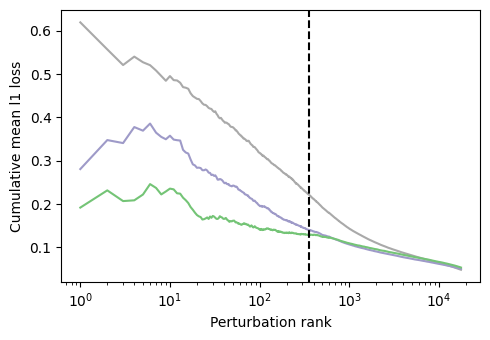

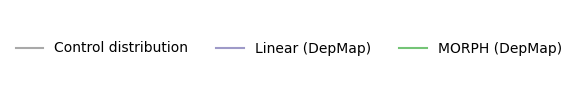

In [46]:
# Simplified bar plot for l1 loss
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

x_ticks = [1e0, 1e1, 1e2, 1e3, 1e4]

# Draw figure using seaborn
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.lineplot(
    data=summary_df_plot,
    x='rank',
    y='mean_l1_loss',
    hue='model',  # Color by model
    palette=model_colors,  # Use a distinct color palette
    ax=ax
)

# Set x-axis ticks and labels
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.xaxis.set_major_formatter(ticker.LogFormatterMathtext())

# Set labels and limits
ax.set_xlabel(r'Perturbation rank', fontsize=10)
ax.set_ylabel('Cumulative mean l1 loss', fontsize=10)

# plot a vertical line at rank_dict['0.01']
ax.axvline(x=int(rank_dict['0.01']), color='black', linestyle='--')

# Remove legend from the main plot
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()

# Save the main plot
plt.tight_layout()
plt.show()

# Create a new figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(1.5, 1))
ax_legend.axis('off')  # Hide axes

# Create the legend in the new figure
legend = ax_legend.legend(handles=handles, labels=labels, loc='center', frameon=False, ncol=4)

# Save the legend separately
plt.show()